# The Internet: Behind the Scenes

The Internet is a transport mechanism that lets any connected device communicate with any other connected device. Behind the scenes:

Each device has a globally distinct IP address, which is a 32 bit number. Usually an IP address is represented as a sequence of four decimal numbers, each number in the range (0, 255). For example, when I checked the IP address for my laptop just now, it was 141.211.203.248. Any IP address beginning with 141.211 is for a device at the University of Michigan. When I take my laptop home and connect to a network there, my laptop gets a different IP address that it uses there.

Data is chopped up into reasonable sized packets (up to 65,535 bytes, but usually much smaller).

Each data packet has a header that includes the destination IP address.

Each packet is routed independently, getting passed on from one computing device to another until it reaches its destination. The computing devices that do that packet forwarding are called routers. Each router keeps an address table that says, when it gets a packet for some destination address, which of its neighbors should it pass the packet on to. The routers are constantly talking to each other passing information about how they should update their routing tables. The system was designed to be resistant to any local damage. If some of the routers stop working, the rest of the routers talk to each other and start routing packets around in a different way so that packets still reach their intended destination if there is some path to get there. It is this technical capability that has spawned metaphoric quotes like this one from John Gilmore: “The Net interprets censorship as damage and routes around it.”

At the destination, the packets are reassembled into the original data message.

<img src = "./routers.png" />

# Anatomy of URLs

A URL is used by a browser or other program to specify what server to connect to and what page to ask for. Like other things that will be interpreted by computer programs, URLs have a very specific formal structure. If you put a colon in the wrong place, the URL won’t work correctly. The overall structure of a URL is:

Usually, the scheme will be http or https. The s in https stands for “secure”. When you use https, all of the communication between the two devices is encrypted. Any devices that intercepts some of the packets along the way will be unable to decrypt the contents and figure out what the data was.

Other schemes that you will sometimes see include ftp (for file transfer) and mailto (for email addresses).

The host will usually be a domain name, like si.umich.edu or github.com or google.com. When the URL specifies a domain name, the first thing the computer program does is look up the domain name to find the 32-bit IP address. For example, right now the IP adddress for github.com is 192.30.252.130. This could change if, for example, github moved its servers to a different location or contracted with a different Internet provider. Lookups use something called the Domain Name System, or DNS for short. Changes to the mapping from domain names to IP addresses can take a little while to propagate: if github.com announces a new IP address associated with its domain, it might take up to 24 hours for some computers to start translating github.com to the new IP address.

Alternatively, the host can be an IP address directly. This is less common, because IP addresses are harder to remember and because a URL containing a domain name will continue to work even if the remote server keeps its domain name but moves to a different IP address.

The :port is optional. If it is omitted, the default port number is 80. The port number is used on the receiving end to decide which computer program should get the data that has been received. We probably will not encounter any URLs that include the : and a port number in this course.

The /path is also optional. It specifies something about which page, or more generally which contents, are being requested.

For example, consider the url https://github.com/presnick/runestone:

https:// says to use the secure http protocol

github.com says to connect to the server at github.com, which currently maps to the IP address 192.30.252.130. The connection will be made on the default port, which is 443 for https.

/presnick/runestone says to ask the remote server for the page presnick/runestone. It is up to the remote server to decide how to map that to the contents of a file it has access to, or to some content that it generates on the fly.

The url http://blueserver.com/path?k=val is another example that we can consider. The path here a bit different from https://github.com/presnick/runestone because it includes what are called “query parameters”, the information after the ?.

<img src="internet_requests.png"/>

# The HTTP protocol

A protocol specifies the order in which parties will speak and the format of what they say and the content of appropriate responses.

HTTP is the protocol that specifies how web browsers or other programs communicate with web servers. One version of the formal specification, before it was later split into multiple documents, was IETF RFC 2616. It is 176 pages long! Fortunately, the basics are pretty easy to understand.

Step 1: the client makes a request to the server.
If the request only involves fetching data, the client sends a message of the form GET <path>, where <path> is the path part of the URL

If the request involves sending some data (e.g., a file upload, or some authentication information), the message starts with POST

In either case, the client sends some HTTP headers. These include:
The type of client program. This allows the server to send back different things to small mobile devices than desktop browsers (a “responsive” website)

Any cookies that the server previously asked the client to hold onto. This allows the server to continue previous interactions, rather than treating every request as stand-alone. It also allows ad networks to place personalized ads.

After the HTTP headers, for a POST type communication, there is some data (the body of the request).

<img src="argumentstoserver.png" />

Step 2: the server responds to the client.
The server first sends back some HTTP headers. These include:
a response code indicating whether the server thinks it has fulfilled the request or not.

a description of the type of content it is sending back (e.g., text/html when it is sending html-formatted text).

any cookies it would like the client to hold onto and send back the next time it communicates with the server.

After the headers come the contents. This is the stuff that you would see if you ask to “View Source” in a browser.

<img src="serverresponse.png" />

#  Using REST APIs

REST stands for REpresentational State Transfer. It originally had a more abstract meaning, but has come to be a shorthand name for web sites that act a bit like python functions, taking as inputs values for certain parameters and producing outputs in the form of a long text string.

API stands for Application Programming Interface. An API specifies how an external program (an application program) can request that a program perform certain computations.

Putting the two together, a REST API specifies how external programs can make HTTP requests to a web site in order to request that some computation be carried out and data returned as output. When a website is designed to accept requests generated by other computer programs, and produce outputs to be consumed by other programs, it is sometimes called a web service, as opposed to a web site which produces output meant for humans to consume in a web browser.

Of course, a web browser is just a computer program, so all requests to web sites come from other computer programs. But usually a browser requests data from a web site in order to display it directly to a human user of the browser.

Prior to the development of REST APIs, there were other ways that computer programs made remote requests to other computers on a network, asking them to perform some computation or retrieve some data. Those other techniques are still in use. REST APIs are particularly convenient, however, both for students and for others, because it is easy to see what is going on in a request and a response between two computers, and thus it is easier to debug.

We will examine a common pattern used in REST APIs, where there is a base URL that defines an “endpoint”, and then additional information is appended to the URL as query parameters, and the response comes back not as HTML but as a format called JSON. Along the way, we will see some functions in python modules that are helpful for constructing the URLS and for processing the JSON formatted response.

# URL Structure for REST APIs

In a REST API, the client or application program– the kind of program you will be writing– makes an HTTP request that includes information about what kind of request it is making. Web sites are free to define whatever format they want for how the request should be formatted. This chapter covers a particularly common and particularly simple format, where the request information is encoded right in the URL. This is convenient, because if something goes wrong, we can debug by copying the URL into a browser and see what happens when it tries to visit that URL.

In this format, the URL has a standard structure:

<li>the base URL</li>
<li>a ? character</li>
<li>one or more key-value pairs, formatted as key=value pairs and separated by the & character.</li>

one or more key-value pairs, formatted as key=value pairs and separated by the & character.

For example, consider the URL https://itunes.apple.com/search?term=Ann+Arbor&entity=podcast. Try copying that URL into a browser, or just clicking on it. It retrieves data about podcasts posted from Ann Arbor, MI. Depending on your browser, it may put the contents into a file attachment that you have to open up to see the contents, or it may just show the contents in a browser window.

Let’s pull apart that URL.

<li>the base URL: https://itunes.apple.com/search</li>
<li>a ? character</li>
<li>key=value pairs. In this case, there are two pairs. The keys are term and entity. An & separates the two pairs.</li>

<img src="urlstructure.png" />

#  Encoding URL Parameters.

Here’s another URL that has a similar format. https://www.google.com/search?q=%22violins+and+guitars%22&tbm=isch. It’s a search on Google for images that match the string “violins and guitars”. It’s not actually based on a REST API, because the contents that come back are meant to be displayed in a browser. But the URL has the same structure we have been exploring above and introduces the idea of “encoding” URL parameters.

<ul>
    The base URL is https://www.google.com/search

?

Two key=value parameters, separated by &

<li>q=%22violins+and+guitars%22 says that the query to search for is “violins and guitars”.</li>

<li>tbm=isch says to go to the tab for image search.</li>
</ul>

<p>Now why is "violins and guitars" represented in the URL as %22violins+and+guitars%22? The answer is that some characters are not safe to include, as is, in URLs. For example, a URL path is not allowed to include the double -quote character. It also can’t include a : or / or a space. Whenever we want to include one of those characters in a URL, we have to encode them with other characters. A space is encoded as +. " is encoded as %22. : would be encoded as %3A. And so on.</p>

# Fetching a page

The web works with a metaphor of “pages”. When you put a URL into a browser, you see a “page” of content.

For example, if you visit https://github.com/RunestoneInteractive/RunestoneServer, you will see the home page for the open source project whose contents are used to run this online textbook.

The browser is just a computer program that fetches the contents and displays them in a nice way. If you want to see what the contents are, in plain text, right click your mouse on the page and select View source, or whatever the equivalent is in your browser.

# Fetching in python with requests.get.

You don’t need to use a browser to fetch the contents of a page, though. In Python, there’s a module available, called requests. You can use the get function in the requests module to fetch the contents of a page.

In [6]:
import requests
import json

page = requests.get("https://api.datamuse.com/words?rel_rhy=funny")
print(type(page))
print(page.text[:150]) # print the first 150 characters
print(page.url) # print the url that was fetched
print("------")
x = page.json() # turn page.text into a python object
print(type(x))
print("---first item in the list---")
print(x[0])
print("---the whole list, pretty printed---")
print(json.dumps(x, indent=2)) # pretty print the results

<class 'requests.models.Response'>
[{"word":"money","score":4415,"numSyllables":2},{"word":"honey","score":1206,"numSyllables":2},{"word":"sunny","score":717,"numSyllables":2},{"word":"
https://api.datamuse.com/words?rel_rhy=funny
------
<class 'list'>
---first item in the list---
{'word': 'money', 'score': 4415, 'numSyllables': 2}
---the whole list, pretty printed---
[
  {
    "word": "money",
    "score": 4415,
    "numSyllables": 2
  },
  {
    "word": "honey",
    "score": 1206,
    "numSyllables": 2
  },
  {
    "word": "sunny",
    "score": 717,
    "numSyllables": 2
  },
  {
    "word": "bunny",
    "score": 702,
    "numSyllables": 2
  },
  {
    "word": "blini",
    "score": 613,
    "numSyllables": 2
  },
  {
    "word": "gunny",
    "score": 449,
    "numSyllables": 2
  },
  {
    "word": "tunny",
    "score": 301,
    "numSyllables": 2
  },
  {
    "word": "sonny",
    "score": 286,
    "numSyllables": 2
  },
  {
    "word": "dunny",
    "score": 245,
    "numSyllables": 2


# More Details of Response objects.

Once we run requests.get, a python object is returned. It’s an instance of a class called Response that is defined in the requests module. We won’t look at it’s definition. Think of it as analogous to the Turtle class. Each instance of the class has some attributes; different instances have different values for the same attribute. All instances can also invoke certain methods that are defined for the class.

In the Runestone environment, we have a very limited version of the requests module available. The Response object has only two attributes that are set, and one method that can be invoked.

<li>The .text attribute. It contains the contents of the file or other information available from the url (or sometimes an error message).</li>
<li>The .url attribute. We will see later that requests.get takes an optional second parameter that is used to add some characters to the end of the base url that is the first parameter. The .url attribute displays the full url that was generated from the input parameters. It can be helpful for debugging purposes; you can print out the URL, paste it into a browser, and see exactly what was returned.</li>
<li>The .json() method. This converts the text into a python list or dictionary, by passing the contents of the .text attribute to the jsons.loads function.</li>

<p>The full Requests module provides some additional attributes in the Response object. These are not implemented in the Runestone environment.</p>

<li>The .status_code attribute.</li>
<ul>
    <li>When a server thinks that it is sending back what was requested, it sends the code 200.</li>
    <li>When the requested page doesn’t exist, it sends back code 404, which is sometimes described as “File Not Found”.</li>
    <li>When the page has moved to a different location, it sends back code 301 and a different URL where the client is supposed to retrieve from. In the full implementation of the requests module, the get function is so smart that when it gets a 301, it looks at the new url and fetches it. For example, github redirects all requests using http to the corresponding page using https (the secure http protocol). Thus, when we ask for http://github.com/presnick/runestone, github sends back a 301 code and the url https://github.com/presnick/runestone. The requests.get function then fetches the other url. It reports a status of 200 and the updated url. We have to do further inquire to find out that a redirection occurred (see below).</li>
</ul>

<li>The .headers attribute has as its value a dictionary consisting of keys and values. To find out all the headers, you can run the code and add a statement print(p.headers.keys()). One of the headers is ‘Content-type’. Some possible values are text/html; charset-utf-8 and application/json; charset=utf-8.</li>
<li>The .history attribute contains a list of previous responses, if there were redirects.</li>

<p>To summarize, a Response object, in the full implementation of the requests module has the following useful attributes that can be accessed in your program:
</p>

<li>.text</li>
<li>.url</li>
<li>.json()</li>
<li>.status_code(not available in Runestone implementation)</li>
<li>.headers (not available in Runestone implementation)</li>
<li>.history (not available in Runestone implementation)</li>

# Using requests.get to encode URL parameters.

<p>Fortunately, when you want to pass information as a URL parameter value, you don’t have to remember all the substitutions that are required to encode special characters. Instead, that capability is built into the requests module.

The get function in the requests module takes an optional parameter called params. If a value is specified for that parameter, it should be a dictionary. The keys and values in that dictionary are used to append something to the URL that is requested from the remote site.

For example, in the following, the base url is https://google.com/search. A dictionary with two parameters is passed. Thus, the whole url is that base url, plus a question mark, “?”, plus a “q=…” and a “tbm=…” separated by an “&”. In other words, the final url that is visited is https://www.google.com/search?q=%22violins+and+guitars%22&tbm=isch. Actually, because dictionary keys are unordered in python, the final url might sometimes have the encoded key-value pairs in the other order: https://www.google.com/search?tbm=isch&q=%22violins+and+guitars%22. Fortunately, most websites that accept URL parameters in this form will accept the key-value pairs in any order.</p>

<div class="card card-body bg-light">
     <blockquote class="blockquote">
         <p class="mb-0">d = {'q': '"violins and guitars"', 'tbm': 'isch'}
             results = requests.get("https://google.com/search", params=d)
             print(results.url)</p>
    </blockquote>
</div>
                

Below are more examples of urls, outlining the base part of the url - which would be the first argument when calling request.get() - and the parameters - which would be written as a dictionary and passed into the params argument when calling request.get().


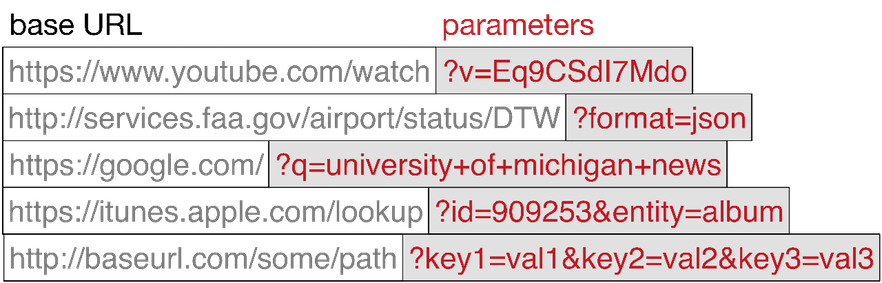


In [1]:
import requests

# page = requests.get("https://api.datamuse.com/words?rel_rhy=funny")
kval_pairs = {'rel_rhy': 'funny'}
page = requests.get("https://api.datamuse.com/words", params=kval_pairs)
print(page.text[:150]) # print the first 150 characters
print(page.url) # print the url that was fetched

[{"word":"money","score":4415,"numSyllables":2},{"word":"honey","score":1206,"numSyllables":2},{"word":"sunny","score":717,"numSyllables":2},{"word":"
https://api.datamuse.com/words?rel_rhy=funny
